# Fit Halo Mass from a Shear Catalog

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster.

## Setup

First, we import some standard packages.

In [1]:
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
from numpy import random
from scipy import optimize as spo
import sys

Next, we import `clmm`'s core modules.

In [2]:
import clmm
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.
We also provide support modules for processing other specific data sets for use with `clmm`.
Any existing support module can be used as a template for creating a new support module for another data set.
If you do make such a support module, please do consider making a pull request so we can add it for others to use.

In [3]:
sys.path.append('./support')
import mock_data as mock

## Making mock data

To create mock data, we need to define a true cosmology, which is currently done with [`astropy`'s cosmology library](http://docs.astropy.org/en/stable/cosmology/index.html).

In [4]:
mock_cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)

We now set some parameters for a mock galaxy cluster.

In [46]:
cosmo = mock_cosmo
cluster_id = "Awesome_cluster"
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngals = 1000
Delta = 200
cluster_ra = 0.0
cluster_dec = 0.0

Then we use the `mock_data` support module to generate a new galaxy catalog.

In [143]:
# noisy_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration,
#                                           cosmo, ngals, Delta, 0.8)

noisy_data_z = mock.generate_galaxy_catalog(cluster_m,
                                            cluster_z,
                                            concentration,
                                            cosmo,
                                            ngals,
                                            Delta,
                                            'chang13',
                                            shapenoise=0.01,
                                            photoz_sigma_unscaled=0.05)

This galaxy catalog is then converted to a `clmm.GalaxyCluster` object.

In [144]:
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, noisy_data_z)

A `clmm.GalaxyCluster` object can be pickled and saved for later use.

In [145]:
gc_object.save('mock_GC.pkl')

Any saved `clmm.GalaxyCluster` object may be read in for analysis.

In [146]:
cl = clmm.load_cluster('mock_GC.pkl')
print("Cluster info = ID:", cl.unique_id, "; ra:", cl.ra, "; dec:", cl.dec,
      "; z_l :", cl.z)
print("The number of source galaxies is :", len(cl.galcat))

ra_l = cl.ra
dec_l = cl.dec
z = cl.z
e1 = cl.galcat['e1']
e2 = cl.galcat['e2']
ra_s = cl.galcat['ra']
dec_s = cl.galcat['dec']

Cluster info = ID: Awesome_cluster ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 1000


We can visualize the distribution of galaxies on the sky.

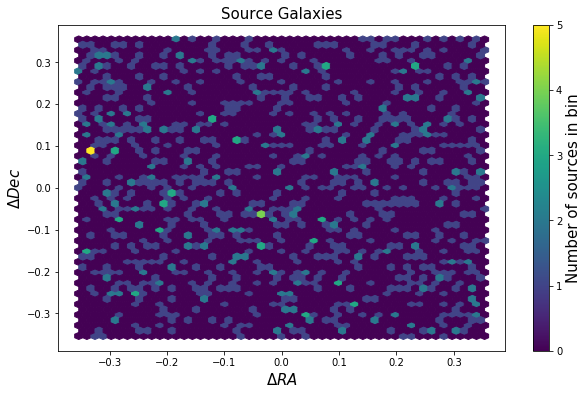

In [147]:
fsize = 15

fig = plt.figure(figsize=(10, 6))
hb = fig.gca().hexbin(ra_s, dec_s, gridsize=50)

cb = fig.colorbar(hb)
cb.set_label('Number of sources in bin', fontsize=fsize)

plt.gca().set_xlabel(r'$\Delta RA$', fontsize=fsize)
plt.gca().set_ylabel(r'$\Delta Dec$', fontsize=fsize)
plt.gca().set_title('Source Galaxies', fontsize=fsize)

plt.show()

`clmm` separates cosmology-dependent and cosmology-independent functionality.

## Deriving observables

We first demonstrate a few of the procedures one can perform on data without assuming a cosmology.

### Computing shear

`clmm.polaraveraging.compute_shear` calculates the tangential and cross shears for each source galaxy in the cluster.

In [148]:
theta, g_t, g_x = pa.compute_shear(cl, geometry="flat")

We can visualize the shear field at each galaxy location.

Text(0.5,0,'angular distance [rad]')

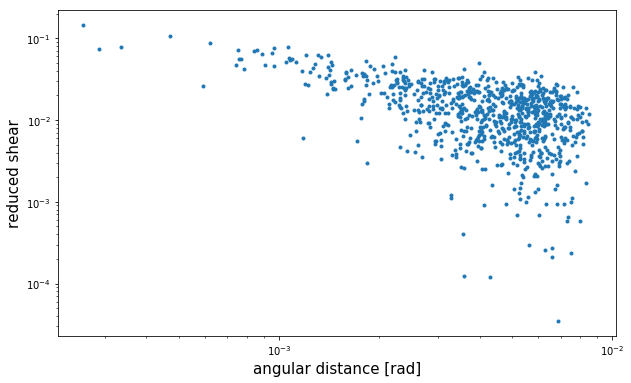

In [149]:
fig = plt.figure(figsize=(10, 6))

fig.gca().loglog(theta, g_t, '.')
plt.ylabel("reduced shear", fontsize=fsize)
plt.xlabel("angular distance [rad]", fontsize=fsize)

### Radially binning the data

Here we compare the reconstructed mass under two different bin definitions.

In [150]:
bin_edges1 = pa.make_bins(0.7, 4, 30)#, method='evenlog10width')

`clmm.polaraveraging.make_shear_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [151]:
profile1 = pa.make_shear_profile(cl, "radians", "Mpc", bins=bin_edges1,
                             cosmo=cosmo)

For later use, we'll define some variables for the binned radius and tangential shear.

We visualize the radially binned shear for our mock galaxies.

Text(0,0.5,'$g_t$')

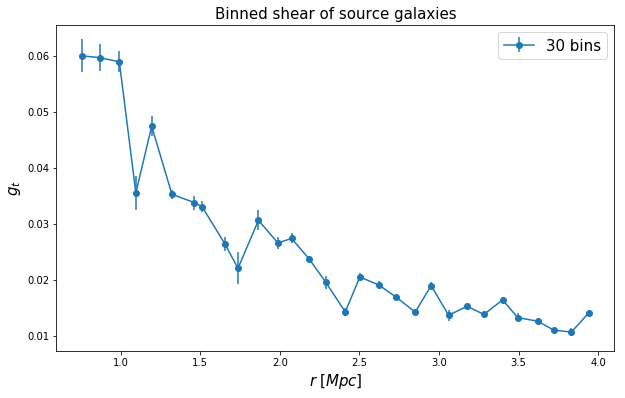

In [152]:
fig = plt.figure(figsize=(10, 6))

fig.gca().errorbar(profile1['radius'], profile1['gt'], yerr=profile1['gt_err'], label='30 bins', marker='o')
plt.legend(fontsize=fsize)

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;[Mpc]$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)

After running `clmm.polaraveraging.make_shear_profile` on a `clmm.GalaxyCluster` object, the object acquires the `clmm.GalaxyCluster.profile` attribute.

In [153]:
cl.profile[0:4]

radius_min,radius,radius_max,gt,gt_err,gx,gx_err,z,z_err
float64,float64,float64,float64,float64,float64,float64,float64,float64
0.7,0.7540249455970154,0.8099999999999999,0.05996386455288569,0.0029274073168855377,3.0527067419044984e-18,1.8282752428240766e-18,0.8954957797990296,0.050399175384968485
0.8099999999999999,0.8661418693086569,0.9199999999999999,0.059656459392282334,0.0023431393022077633,6.938893903907229e-19,1.6996749443881478e-19,1.3205054325702492,0.12753985576812527
0.9199999999999999,0.9907528184265646,1.03,0.05889802367141957,0.001856196595661753,-6.505213034913027e-19,2.823925224926892e-19,1.3950963983894922,0.09897410206430578
1.03,1.0943770022036465,1.14,0.03548139799101414,0.002996868176825315,4.553649124439119e-18,1.3286904709614813e-18,1.1673732588609156,0.13257820921928304


## Modeling the data

We next demonstrate a few of the procedures one can perform once a cosmology has been chosen.

### Choosing a halo model

`clmm.modeling.predict_reduced_tangential_shear` supports various parametric halo profile functions, including `nfw`.
`clmm.modeling` works in units of $Mpc/h$, whereas the data is cosmology-independent, with units of $Mpc$.

In [193]:
# chi2 definition to be used with scipy.optimize.minimize
def nfw_to_shear_profile(logm, profile_info):
    [r, gt, gt_err, z_src] = profile_info
    m = 10.**logm
    gt_model = clmm.predict_reduced_tangential_shear(r*cosmo.h,
                                                     m, concentration,
                                                     cluster_z, z_src, cosmo,
                                                     delta_mdef=200,
                                                     halo_profile_model='nfw')
    return sum(((gt_model - gt)/gt_err)**2)

In [194]:
# model definition to be used with scipy.optimize.curve_fit
def shear_profile_model(r, logm, z_src):
    m = 10.**logm
    gt_model = clmm.predict_reduced_tangential_shear(r*cosmo.h,
                                                     m, concentration,
                                                     cluster_z, z_src, cosmo,
                                                     delta_mdef=200,
                                                     halo_profile_model='nfw')
    return gt_model

### Fitting a halo mass

We optimize to find the best-fit mass for the data under the two radial binning schemes.

In [205]:
# example using scipy.optimize.minimize
logm_0 = random.uniform(13., 17., 1)[0]

logm_est1 = spo.minimize(nfw_to_shear_profile, logm_0,
                         args=[profile1['radius'], profile1['gt'], profile1['gt_err'], profile1['z']])

m_est1 = 10.**logm_est1.x
print(f'Best fit mass = {m_est1[0]} Msun')



Best fit mass = 849101782223009.4 Msun


In [206]:
# example using scipy.optimize.curve_fit

popt,pcov = spo.curve_fit(lambda r, logm:shear_profile_model(r, logm, profile1['z']), 
                    profile1['radius'], 
                    profile1['gt'], 
                    sigma=profile1['gt_err'], bounds=[13.,17.])

m_est1 = 10.**popt[0]
m_est1_err =  10.**np.sqrt(pcov[0][0])
print(f'Best fit mass = {m_est1} +/- {m_est1_err} Msun')

Best fit mass = 849101815542747.0 +/- 1.0314778424326092 Msun


Next, we calculate the reduced tangential shear predicted by the two models.

In [156]:
rr = np.logspace(-0.5, np.log10(5), 100)

gt_model1 = clmm.predict_reduced_tangential_shear(rr*cosmo.h,
                                                  m_est1, concentration,
                                                  cluster_z, np.mean(cl.galcat['z']), cosmo,
                                                  delta_mdef=200,
                                                  halo_profile_model='nfw')

We visualize the two predictions of reduced tangential shear.

Text(0,0.5,'reduced tangential shear')

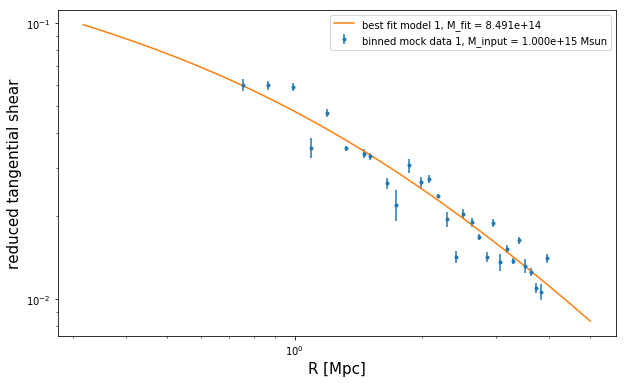

In [157]:
fig = plt.figure(figsize=(10, 6))

fig.gca().errorbar(profile1['radius'], profile1['gt'],profile1['gt_err'],
                  label='binned mock data 1, M_input = %.3e Msun' % cluster_m, fmt='.')
fig.gca().plot(rr, gt_model1,
               label='best fit model 1, M_fit = %.3e' % m_est1)

plt.semilogx()
plt.semilogy()

plt.legend()
plt.xlabel('R [Mpc]', fontsize=fsize)
plt.ylabel('reduced tangential shear', fontsize=fsize)